In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw

In [2]:
width = 216
height = 216
num_classes = 2
classes = ["Circle", "No-Circle"]

In [3]:
TRAINING_CSV_FILE = 'Data/training_data.csv'
VALIDATION_CSV_FILE = 'Data/validation_data.csv'
TRAINING_IMAGE_DIR = 'Images/Training'
VALIDATION_IMAGE_DIR = 'Images/Validation'

training_image_records = pd.read_csv(TRAINING_CSV_FILE)
validation_image_records = pd.read_csv(VALIDATION_CSV_FILE)

train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)
validation_image_path = os.path.join(os.getcwd(), VALIDATION_IMAGE_DIR)

train_images = []
train_targets = []
train_labels = []

for index, row in training_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    train_image_fullpath = os.path.join(train_image_path, filename)
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width))
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)
    
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    train_images.append(train_img_arr)
    train_targets.append((xmin, ymin, xmax, ymax))
    train_labels.append(classes.index(class_name))
    
    
    
validation_images = []
validation_targets = []
validation_labels = []

for index, row in validation_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    validation_image_fullpath = os.path.join(validation_image_path, filename)
    validation_img = keras.preprocessing.image.load_img(validation_image_fullpath, target_size=(height, width))
    validation_img_arr = keras.preprocessing.image.img_to_array(validation_img)
    #img_arr = img_arr/255.0
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    validation_images.append(validation_img_arr)
    validation_targets.append((xmin, ymin, xmax, ymax))
    validation_labels.append(classes.index(class_name))

In [4]:
#create the common input layer
input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape)

In [5]:
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch)  

locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [6]:
model = tf.keras.Model(input_layer, outputs=[classifier_branch, locator_branch])

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 216, 216, 3) 0                                            
__________________________________________________________________________________________________
bl_1 (Rescaling)                (None, 216, 216, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
bl_2 (Conv2D)                   (None, 216, 216, 16) 448         bl_1[0][0]                       
__________________________________________________________________________________________________
bl_3 (MaxPooling2D)             (None, 108, 108, 16) 0           bl_2[0][0]                       
______________________________________________________________________________________________

In [8]:
losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "bb_head":tf.keras.losses.MSE}


In [9]:
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [10]:
training_epochs = 20

train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)

validation_images = np.array(validation_images)
validation_targets = np.array(validation_targets)
validation_labels = np.array(validation_labels)

In [11]:
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}

validationTargets = {
    "cl_head": validation_labels,
    "bb_head": validation_targets
}

In [12]:
print(type(trainTargets))

<class 'dict'>


In [13]:
history = model.fit(train_images, trainTargets,
                   validation_data=(validation_images, validationTargets),
                   batch_size=4,
                   epochs=training_epochs,
                   shuffle=True,
                   verbose=1)

Epoch 1/20
28/28 [==============================] - 13s 456ms/step - loss: 0.0736 - cl_head_loss: 0.0234 - bb_head_loss: 0.0502 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.4732 - val_loss: 0.0313 - val_cl_head_loss: 9.4198e-06 - val_bb_head_loss: 0.0313 - val_cl_head_accuracy: 1.0000 - val_bb_head_accuracy: 0.6429
Epoch 2/20
28/28 [==============================] - 13s 452ms/step - loss: 0.0201 - cl_head_loss: 1.1655e-05 - bb_head_loss: 0.0201 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.7054 - val_loss: 0.0091 - val_cl_head_loss: 1.4932e-06 - val_bb_head_loss: 0.0091 - val_cl_head_accuracy: 1.0000 - val_bb_head_accuracy: 0.5714
Epoch 3/20
28/28 [==============================] - 13s 451ms/step - loss: 0.0074 - cl_head_loss: 3.4365e-06 - bb_head_loss: 0.0074 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.8750 - val_loss: 0.0033 - val_cl_head_loss: 0.0000e+00 - val_bb_head_loss: 0.0033 - val_cl_head_accuracy: 1.0000 - val_bb_head_accuracy: 0.8571
Epoch 4/20
28/28 [===========

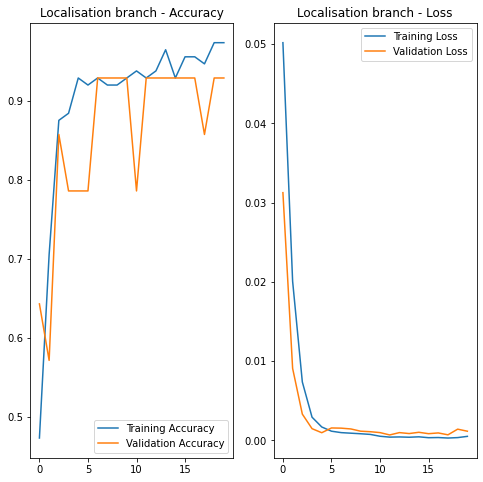

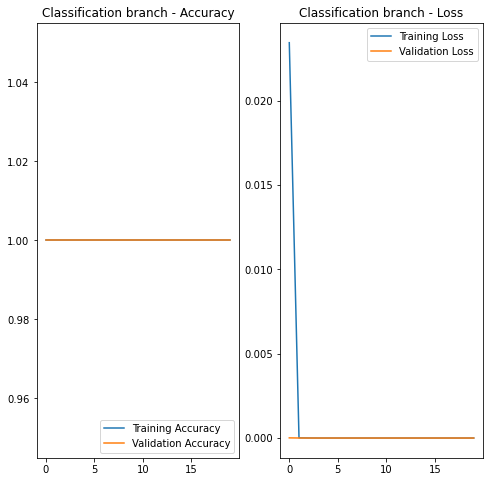

In [14]:
cl_accuracy = history.history['cl_head_accuracy']
cl_val_acc = history.history['val_cl_head_accuracy']

bb_accuracy = history.history['bb_head_accuracy']
bb_val_acc = history.history['val_bb_head_accuracy']

cl_loss = history.history['cl_head_loss']
cl_val_loss = history.history['val_cl_head_loss']

bb_loss = history.history['bb_head_loss']
bb_val_loss = history.history['val_bb_head_loss']



epochs_range = range(training_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bb_accuracy, label='Training Accuracy')
plt.plot(epochs_range, bb_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Localisation branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, bb_loss, label='Training Loss')
plt.plot(epochs_range, bb_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Localisation branch - Loss')
plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cl_accuracy, label='Training Accuracy')
plt.plot(epochs_range, cl_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Classification branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, cl_loss, label='Training Loss')
plt.plot(epochs_range, cl_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Classification branch - Loss')
plt.show()



In [15]:
validation_img = 'Test/20210620_155720.jpg'

img = keras.preprocessing.image.load_img(validation_img, target_size=(height, width))

img = keras.preprocessing.image.img_to_array(img)
img = tf.expand_dims(img, 0)
predictions = model.predict(img)

In [16]:
print(predictions[1][0])

[0.3076216  0.36437163 0.56261694 0.55307895]


In [17]:
bbox = predictions[1][0]
bbox = [bbox[0] * width, bbox[1] * height, bbox[2] * width, bbox[3] * height]
print(bbox)

class_prediction_value = predictions[0][0]
score = tf.nn.softmax(class_prediction_value)

print(score)
score = tf.math.argmax(score)
print("Predicted class: {}".format(classes[score]))

[66.44626522064209, 78.7042715549469, 121.52525997161865, 119.46505308151245]
tf.Tensor([1.000000e+00 5.948679e-08], shape=(2,), dtype=float32)
Predicted class: Circle


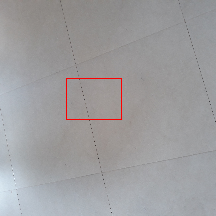

In [18]:
testimg = keras.preprocessing.image.load_img(validation_img, target_size=(height, width))
draw1 = Draw(testimg)
draw1.rectangle(bbox, outline='red')
testimg

In [19]:
model.save('./Saved-Models/Locator')

INFO:tensorflow:Assets written to: ./Saved-Models/Locator/assets


In [20]:
for layer in model.layers:
    if layer.name.startswith('bl_'):
        print(layer.name)
        layer.trainable = False
        
for layer in model.layers:
    if layer.name.startswith('bb_'):
        print(layer.name)
        layer.trainable = False

bl_1
bl_2
bl_3
bl_4
bl_5
bl_6
bl_7
bl_8
bb_1
bb_2
bb_3
bb_head
